In [1]:
# Cell 1: Imports & setup
import os
import json
from pprint import pprint
from pathlib import Path

import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

from sklearn.metrics import precision_recall_fscore_support, mean_absolute_error
from scipy.stats import pearsonr


# src modules (assumes you have src/ on the PYTHONPATH or running from repo root)
from src.extractors import get_nlp, spacy_ner, extract_svo_from_doc, extract_svo_from_sent
from src.normalize import canonicalize, _simple_canonical_name  # _simple_canonical_name used for lightweight text matching
from src.kg_builder import build_graph, graph_to_jsonld, save_jsonld
from src.llm_client import call_llm


In [2]:
DATA_PATH = Path("data/synthetic_v1.json")
PROMPT_RE = Path("prompts/re_G4.txt")
PROMPT_PERS = Path("prompts/pers_H.txt")
OUT_DIR = Path("notebooks_output")
OUT_DIR.mkdir(parents=True, exist_ok=True)

In [3]:
# Cell 2: Load data/synthetic_v1.json
assert DATA_PATH.exists(), f"Data file not found: {DATA_PATH} - please place your synthetic_v1.json there."
with open(DATA_PATH, 'r', encoding='utf8') as f:
    docs = json.load(f)

print(f"Loaded {len(docs)} documents")
pprint(docs[0])

Loaded 10 documents
{'doc_id': 'D1',
 'gold_entities': [{'id': 'D1_E1', 'text': 'Alice', 'type': 'Person'},
                   {'id': 'D1_E2',
                    'text': 'Acme Corp',
                    'type': 'Organization'}],
 'gold_relations': [{'obj_id': 'D1_E2', 'pred': 'worksAt', 'subj_id': 'D1_E1'},
                    {'obj_id': 'D1_E2', 'pred': 'role', 'subj_id': 'D1_E1'}],
 'personality_labels': {'D1_E1': {'big5': {'agreeableness': 0.75,
                                           'conscientiousness': 0.92,
                                           'extraversion': 0.7,
                                           'neuroticism': 0.2,
                                           'openness': 0.6},
                                  'explanation': 'High conscientiousness '
                                                 "because she 'consistently "
                                                 "met deadlines' and organized "
                                                 'meet

In [4]:
# Cell 3: spaCy NER (call src/extractors.spacy_ner)
nlp = get_nlp()
ner_results = {}
for doc in docs:
    doc_id = doc["doc_id"]
    text = doc["text"]
    ents = spacy_ner(text)
    ner_results[doc_id] = ents

print("Example NER for first doc:")
pprint(ner_results[docs[0]["doc_id"]])


Example NER for first doc:
[{'end_char': 5, 'label': 'ORG', 'start_char': 0, 'text': 'Alice'},
 {'end_char': 22, 'label': 'ORG', 'start_char': 13, 'text': 'Acme Corp'},
 {'end_char': 54, 'label': 'DATE', 'start_char': 44, 'text': 'last month'},
 {'end_char': 76, 'label': 'DATE', 'start_char': 70, 'text': 'weekly'}]


In [5]:
# Cell 4: SVO extractors (call extract_svo_from_sent / extract_svo_from_doc)
svo_results = {}
for doc in docs:
    doc_id = doc["doc_id"]
    text = doc["text"]
    res = extract_svo_from_doc(text)
    # res contains sentences and svos with sentence_index
    svo_results[doc_id] = res

print("SVOs for D1:")
pprint(svo_results["D1"])


SVOs for D1:
{'sentences': ['Alice joined Acme Corp as a project manager last month.',
               'She organized weekly meetings and consistently met deadlines '
               'to keep the team on schedule.'],
 'svos': [{'obj': 'Corp',
           'obj_span': (18, 22),
           'sent_text': 'Alice joined Acme Corp as a project manager last '
                        'month.',
           'sentence_index': 0,
           'subj': 'Alice',
           'subj_span': (0, 5),
           'verb': 'join'},
          {'obj': 'meetings',
           'obj_span': (77, 85),
           'sent_text': 'She organized weekly meetings and consistently met '
                        'deadlines to keep the team on schedule.',
           'sentence_index': 1,
           'subj': 'She',
           'subj_span': (56, 59),
           'verb': 'organize'},
          {'obj': 'deadlines',
           'obj_span': (107, 116),
           'sent_text': 'She organized weekly meetings and consistently met '
                    

In [10]:
# Cell 5: Optional - Run LLM RE prompt (prompts/re_G4.txt) on sentences
llm_re_results = {}
if PROMPT_RE.exists():
    print(f"Found RE prompt at {PROMPT_RE}; running LLM (or simulator) per sentence")
    for doc in docs:
        doc_id = doc["doc_id"]
        sent_list = svo_results[doc_id]["sentences"]
        llm_re_results[doc_id] = []
        for sent in sent_list:
            payload = {"text": sent}
            try:
                resp = call_llm(str(PROMPT_RE), payload)
            except Exception as e:
                # record the error and continue
                resp = {"error": str(e)}
            llm_re_results[doc_id].append({"sentence": sent, "llm_resp": resp})
    print("Completed LLM RE (simulated or live) for docs that had the prompt file.")
else:
    print(f"Prompt {PROMPT_RE} not found — skipping LLM-based RE. To run, add a prompt file at prompts/re_G4.txt")


Found RE prompt at prompts/re_G4.txt; running LLM (or simulator) per sentence
Completed LLM RE (simulated or live) for docs that had the prompt file.


In [11]:
# Cell 6: Normalize relations
# We'll prepare predictions from SVOs and (if available) LLM-extracted relations.
pred_relations = {}

def text_to_entity_id(doc, surface_text):
    """Map a surface mention to gold entity id in the document by simple canonical match (best-effort).
    Falls back to creating a synthetic ID if not found.
    """
    cand = surface_text.strip()
    cand_c = _simple_canonical_name(cand).lower()
    for e in doc.get("gold_entities", []):
        if _simple_canonical_name(e["text"]).lower() == cand_c:
            return e["id"]
    # fallback: make a new id
    return f"{doc['doc_id']}_GEN_{cand_c.replace(' ', '_')[:30]}"

for doc in docs:
    doc_id = doc["doc_id"]
    pred_relations[doc_id] = []
    # from SVO extractor
    for s in svo_results[doc_id]["svos"]:
        subj_text = s["subj"]
        obj_text = s["obj"]
        subj_id = text_to_entity_id(doc, subj_text)
        obj_id = text_to_entity_id(doc, obj_text)
        pred = s["verb"]
        pred_relations[doc_id].append({"subj_id": subj_id, "pred": pred, "obj_id": obj_id, "evidence": s.get("sent_text")})
    # from LLM RE if available
    if llm_re_results.get(doc_id):
        for item in llm_re_results[doc_id]:
            resp = item["llm_resp"]
            if isinstance(resp, dict) and resp.get("extracted"):
                for ex in resp["extracted"]:
                    subj_id = text_to_entity_id(doc, ex.get("subj", ""))
                    obj_id = text_to_entity_id(doc, ex.get("obj", ""))
                    pred_relations[doc_id].append({"subj_id": subj_id, "pred": ex.get("pred", "unknown"), "obj_id": obj_id, "evidence": item["sentence"]})

    # canonicalize the relations using src.normalize.canonicalize
    # canonicalize expects a list of entities and relations; we'll convert back-and-forth
    ent_list = doc.get("gold_entities", [])
    rel_list = []
    for r in pred_relations[doc_id]:
        rel_list.append({"subj_id": r["subj_id"], "pred": r["pred"], "obj_id": r["obj_id"]})
    canon = canonicalize(ent_list, rel_list)
    pred_relations[doc_id] = canon["relations"]

print("Normalized relations for D1:")
pprint(pred_relations["D1"])


Normalized relations for D1:
[{'obj_id': 'D1_GEN_corp', 'pred': 'join', 'subj_id': 'D1_E1'},
 {'obj_id': 'D1_GEN_meetings', 'pred': 'organize', 'subj_id': 'D1_GEN_she'},
 {'obj_id': 'D1_GEN_deadlines', 'pred': 'meet', 'subj_id': 'D1_GEN_she'},
 {'obj_id': 'D1_GEN_team', 'pred': 'keep', 'subj_id': 'D1_GEN_she'},
 {'obj_id': 'D1_GEN_corp', 'pred': 'worksAt', 'subj_id': 'D1_E1'},
 {'obj_id': 'D1_E2', 'pred': 'worksAt', 'subj_id': 'D1_GEN_she'}]


Graph nodes: 80, edges: 51
Saved graph visualization to notebooks_output/kg_demo.png
Saved KG JSON-LD to notebooks_output/kg_output_demo.json


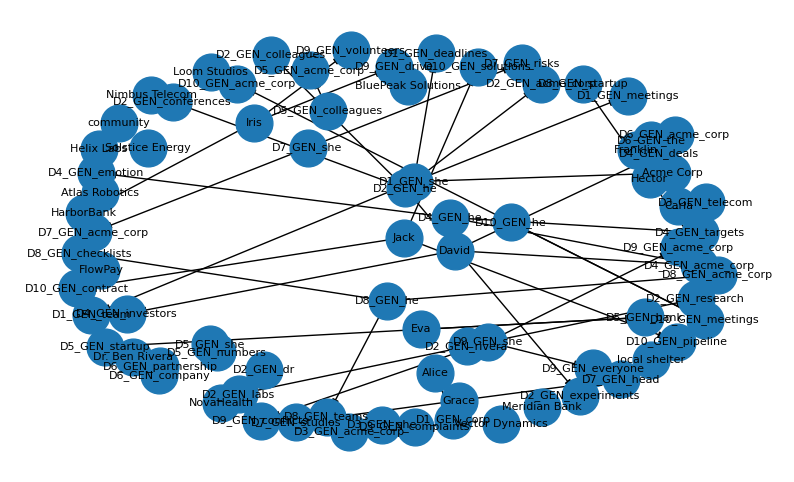

In [8]:
# Cell 7: Build KG (NetworkX) from normalized triples and export JSON-LD
all_entities = []
all_rels = []
for doc in docs:
    all_entities.extend(doc.get("gold_entities", []))
    # rels we use preds from pred_relations (preds already canonicalized)
    for r in pred_relations.get(doc["doc_id"], []):
        # ensure subj/obj exist as nodes - if synthetic ids were created earlier, ensure we have a text label
        subj = r["subj_id"]
        obj = r["obj_id"]
        all_rels.append({"subj_id": subj, "pred": r.get("pred"), "obj_id": obj})

# ensure unique entities by id (prefer gold entities' text)
unique_entities = {}
for e in all_entities:
    unique_entities[e["id"]] = e

# create node entries for any synthetic ids referenced in relations but not in unique_entities
for r in all_rels:
    if r["subj_id"] not in unique_entities:
        unique_entities[r["subj_id"]] = {"id": r["subj_id"], "text": r["subj_id"], "type": "Unknown"}
    if r["obj_id"] not in unique_entities:
        unique_entities[r["obj_id"]] = {"id": r["obj_id"], "text": r["obj_id"], "type": "Unknown"}

entities_for_graph = list(unique_entities.values())
relations_for_graph = all_rels

G = build_graph(entities_for_graph, relations_for_graph)
print(f"Graph nodes: {G.number_of_nodes()}, edges: {G.number_of_edges()}")

# draw the graph (small layout) and save PNG
plt.figure(figsize=(10, 6))
pos = nx.spring_layout(G, seed=42)
node_labels = {n: data.get('text', n) for n, data in G.nodes(data=True)}
nx.draw_networkx_nodes(G, pos, node_size=700)
nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8)
edge_labels = {(u, v): d for u, v, k, d in G.edges(keys=True, data=True)}
nx.draw_networkx_edges(G, pos, arrows=True)
plt.axis('off')
png_path = OUT_DIR / "kg_demo.png"
plt.savefig(png_path, bbox_inches='tight', dpi=150)
print(f"Saved graph visualization to {png_path}")

# export JSON-LD
jsonld = graph_to_jsonld(G)
kg_out = OUT_DIR / "kg_output_demo.json"
with open(kg_out, 'w', encoding='utf8') as f:
    json.dump(jsonld, f, indent=2, ensure_ascii=False)
print(f"Saved KG JSON-LD to {kg_out}")


In [12]:
def rule_based_personality_for_person(name: str, text: str) -> dict:
    """Return big5 dict for a person using simple keyword heuristics.
    This is intentionally simple and deterministic for reproducibility.
    """
    t = text.lower()
    score = {"openness": 0.5, "conscientiousness": 0.5, "extraversion": 0.5, "agreeableness": 0.5, "neuroticism": 0.5}
    # simple rules
    if any(k in t for k in ["creative", "creative risks", "bold", "founder", "innov"]):
        score["openness"] = min(1.0, score["openness"] + 0.3)
    if any(k in t for k in ["meticulous", "rechecks", "deadlines", "organized", "organized weekly", "organize"]):
        score["conscientiousness"] = min(1.0, score["conscientiousness"] + 0.4)
    if any(k in t for k in ["speaks at", "greets", "recruits", "leading", "lead", "meets investors", "speaks"]):
        score["extraversion"] = min(1.0, score["extraversion"] + 0.3)
    if any(k in t for k in ["volunteer", "patiently resolves", "resolves complaints", "empathy", "warmly", "support"]):
        score["agreeableness"] = min(1.0, score["agreeableness"] + 0.4)
    if any(k in t for k in ["warns about", "pitfalls", "cautious", "anx", "worry", "rarely shows emotion"]):
        score["neuroticism"] = min(1.0, score["neuroticism"] + 0.2)
    # rounding to two decimals as per guideline
    score = {k: round(v, 2) for k, v in score.items()}
    return score

rule_personality = {}
for doc in docs:
    doc_scores = {}
    for ent in doc.get("gold_entities", []):
        if ent["type"] != "Person":
            continue
        # find evidence sentences containing the person's name
        name = ent["text"]
        # gather doc-level text (could refine to sentence spans)
        score = rule_based_personality_for_person(name, doc["text"]) 
        doc_scores[ent["id"]] = {"big5": score, "explanation": "rule-based heuristics: keywords found in document text."}
    rule_personality[doc["doc_id"]] = doc_scores

print("Rule-based personality for D1:")
pprint(rule_personality.get("D1"))


Rule-based personality for D1:
{'D1_E1': {'big5': {'agreeableness': 0.5,
                    'conscientiousness': 0.9,
                    'extraversion': 0.5,
                    'neuroticism': 0.5,
                    'openness': 0.5},
           'explanation': 'rule-based heuristics: keywords found in document '
                          'text.'}}


In [13]:
# Cell 9: Personality - LLM-based comparison (prompts/pers_H.txt)
llm_personality = {}
if PROMPT_PERS.exists():
    for doc in docs:
        doc_id = doc["doc_id"]
        llm_personality[doc_id] = {}
        for ent in doc.get("gold_entities", []):
            if ent["type"] != "Person":
                continue
            payload = {"text": doc["text"], "person": ent["text"]}
            try:
                resp = call_llm(str(PROMPT_PERS), payload)
            except Exception as e:
                resp = {"error": str(e)}
            # store raw LLM output for later parsing/analysis
            llm_personality[doc_id][ent["id"]] = resp
    print("Completed LLM personality runs (simulated if no API key)")
else:
    print(f"Prompt {PROMPT_PERS} not found — skipping LLM personality. To run, add prompts/pers_H.txt")


Completed LLM personality runs (simulated if no API key)


In [ ]:
# Cell 10: Simple Evaluation
## Relations: compare predicted canonical relations to gold_relations at doc level
def flatten_rel_list(rel_list):
    return [(r["subj_id"], r.get("pred"), r["obj_id"]) for r in rel_list]

y_true = []
y_pred = []
for doc in docs:
    doc_id = doc["doc_id"]
    gold = flatten_rel_list(doc.get("gold_relations", []))
    pred = flatten_rel_list(pred_relations.get(doc_id, []))
    # create sets for simple matching
    gold_set = set(gold)
    pred_set = set(pred)
    tp = len(gold_set & pred_set)
    fp = len(pred_set - gold_set)
    fn = len(gold_set - pred_set)
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0.0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0.0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) > 0 else 0.0
    print(f"Doc {doc_id}: P={precision:.2f}, R={recall:.2f}, F1={f1:.2f} (TP={tp},FP={fp},FN={fn})")

## Personality: MAE + Pearson (per trait) comparing rule-based to gold (if gold provided)
traits = ["openness", "conscientiousness", "extraversion", "agreeableness", "neuroticism"]
all_maes = {t: [] for t in traits}
all_golds = {t: [] for t in traits}
all_preds = {t: [] for t in traits}

for doc in docs:
    doc_id = doc["doc_id"]
    gold_persons = doc.get("personality_labels", {})
    rule_persons = rule_personality.get(doc_id, {})
    for pid, gold in gold_persons.items():
        gold_scores = gold.get("big5", {})
        pred_scores = rule_persons.get(pid, {}).get("big5")
        if pred_scores is None:
            continue
        for t in traits:
            g = gold_scores.get(t)
            p = pred_scores.get(t)
            if g is None or p is None:
                continue
            all_golds[t].append(g)
            all_preds[t].append(p)

for t in traits:
    if len(all_golds[t]) == 0:
        print(f"Trait {t}: no gold/pred pairs to evaluate")
        continue
    mae = mean_absolute_error(all_golds[t], all_preds[t])
    pearson_r, pval = pearsonr(all_golds[t], all_preds[t]) if len(all_golds[t]) > 1 else (np.nan, np.nan)
    print(f"Trait {t}: MAE={mae:.3f}, Pearson r={pearson_r:.3f} (n={len(all_golds[t])})")


Doc D1: P=0.00, R=0.00, F1=0.00 (TP=0,FP=6,FN=2)
Doc D2: P=0.00, R=0.00, F1=0.00 (TP=0,FP=7,FN=2)
Doc D3: P=0.00, R=0.00, F1=0.00 (TP=0,FP=3,FN=2)
Doc D4: P=0.00, R=0.00, F1=0.00 (TP=0,FP=6,FN=2)
Doc D5: P=0.00, R=0.00, F1=0.00 (TP=0,FP=5,FN=2)
Doc D6: P=0.00, R=0.00, F1=0.00 (TP=0,FP=3,FN=3)
Doc D7: P=0.00, R=0.00, F1=0.00 (TP=0,FP=4,FN=2)
Doc D8: P=0.00, R=0.00, F1=0.00 (TP=0,FP=5,FN=1)
Doc D9: P=0.00, R=0.00, F1=0.00 (TP=0,FP=6,FN=2)
Doc D10: P=0.00, R=0.00, F1=0.00 (TP=0,FP=6,FN=2)
Trait openness: MAE=0.124, Pearson r=0.921 (n=10)
Trait conscientiousness: MAE=0.197, Pearson r=0.508 (n=10)
Trait extraversion: MAE=0.166, Pearson r=0.529 (n=10)
Trait agreeableness: MAE=0.111, Pearson r=0.751 (n=10)
Trait neuroticism: MAE=0.268, Pearson r=0.426 (n=10)


In [15]:
artifacts = {
    "kg_jsonld": str(kg_out),
    "kg_png": str(png_path),
    "pred_relations": pred_relations,
    "rule_personality": rule_personality,
    "llm_personality_raw": llm_personality,
}

out_art = OUT_DIR / "pipeline_artifacts.json"
with open(out_art, 'w', encoding='utf8') as f:
    json.dump(artifacts, f, indent=2, ensure_ascii=False)
print(f"Saved pipeline artifacts summary to {out_art}")


Saved pipeline artifacts summary to notebooks_output/pipeline_artifacts.json
